In [5]:
from scipy.stats import beta
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from bokeh.palettes import Category20_20
import arviz as az

**首先我们构造一个数据集， 就这样吧**

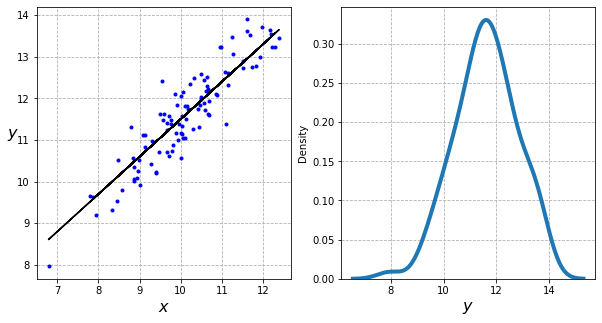

In [25]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.grid(linestyle = '--')
plt.plot(x, y_real, 'k')

plt.subplot(1,2,2)
sns.kdeplot(y, linewidth = 4)
plt.xlabel('$y$', fontsize=16)
plt.grid(linestyle = '--')
plt.show()

#### Some simple math


Total sum of squares $SS_{tot} = \sum_{i} (y_{i} - \overline{y})^2$  --  Variance of y       
Residule sum of squares $SS_{res} = \sum_{i} (y_{i} - f_{i})^2$  --  Variance no explained by the model    

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ - Proportion of variance explained by the model     

Regression sum of squares $SS_{reg} = \sum_{i} (f_{i} - \overline{y})^2$               
$SS_{tot} = SS_{res} + SS_{reg} $

$R^2 = \frac{SS_{tot}}{SS_{tot}} - \frac{SS_{res}}{SS_{tot}} = \frac{SS_{reg}}{SS_{tot}}$        


$slope = r * \frac{S_{y}}{S_{x}}$          

1. Pearson r在数值上等于$R^2$开根号
2. Pearson 可以和斜率互相换算

In [29]:
with pm.Model() as model:
    alpha = pm.Normal('alpha',mu = 4, sigma = 10)
    beta = pm.Normal('beta',mu = 0, sigma = 1)
    epsilon = pm.HalfCauchy('epsilon',5)
    
    mu = alpha +  beta * x
    
    y_pred = pm.Normal('y_pred', mu = mu, sigma = epsilon, observed = y)
    
    rb = pm.Deterministic('rb',(beta * x.std() / y.std()) ** 2)
    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) **2)
    rss = pm.Deterministic('rss',ss_reg / ss_tot)
    
    step = pm.NUTS()
    trace = pm.sample(10000,step = step,tune=5000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 49 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


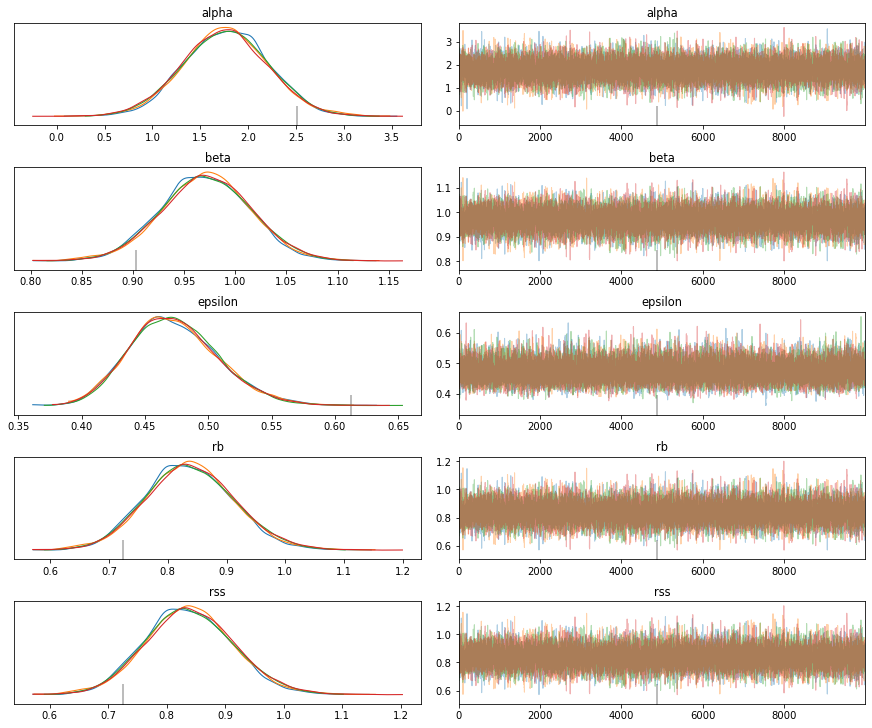

In [30]:
az.plot_trace(trace)
plt.show()

In [32]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.765,0.446,0.929,2.597,0.004,0.003,13244.0,13244.0,13262.0,14193.0,1.0
beta,0.971,0.044,0.888,1.052,0.000,0.000,13236.0,13195.0,13259.0,14092.0,1.0
epsilon,0.473,0.035,0.410,0.540,0.000,0.000,16590.0,16590.0,16380.0,13667.0,1.0
rb,0.838,0.075,0.699,0.981,0.001,0.000,13195.0,13092.0,13259.0,14092.0,1.0
rss,0.839,0.075,0.700,0.983,0.001,0.000,13204.0,13098.0,13270.0,14114.0,1.0


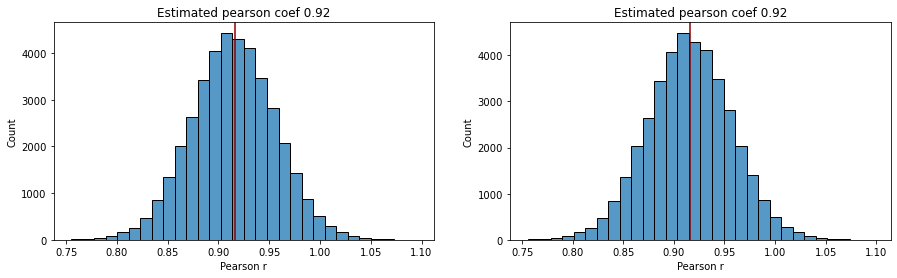

In [83]:
est_perason = np.sqrt(0.839)

fig, ax = plt.subplots(figsize = (15,4))
plt.subplot(1,2,1)
sns.histplot(np.sqrt(trace.posterior['rb'].values.reshape(-1)), bins = 30)
plt.axvline(est_perason, color = 'darkred')
plt.title('Estimated pearson coef {}'.format(round(est_perason,2)))
plt.xlabel('Pearson r')

plt.subplot(1,2,2)
sns.histplot(np.sqrt(trace.posterior['rss'].values.reshape(-1)), bins = 30)
plt.axvline(est_perason, color = 'darkred')
plt.title('Estimated pearson coef {}'.format(round(est_perason,2)))
plt.xlabel('Pearson r')
plt.show()

In [81]:
np.corrcoef(x,y)[0,1]

0.9165263164641536

感觉挺好得

### Pearson coefficient from multivariate Gaussian               

In [84]:
np.cov(x,y)

array([[1.19913624, 1.16750705],
       [1.16750705, 1.35319573]])

In [104]:
def cov_by_hand(x,y):
    # you only need the 3 things to compute cov
    sigmax = x.std(ddof = 1)
    sigmay = y.std(ddof = 1)
    rho_xy = np.corrcoef(x,y)[0,1]
        
    varx = sigmax ** 2
    vary = sigmay ** 2
    cov_xy = rho_xy* sigmax * sigmay
    cov = np.array([[varx,cov_xy ],[cov_xy, vary]])
    return cov

In [105]:
cov_by_hand(x,y)

array([[1.19913624, 1.16750705],
       [1.16750705, 1.35319573]])